# Libraries

In [1]:
import pandas as pd
import seaborn as sns
from os.path import exists
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack, csr_matrix
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Text preprocessing libraries
import re
import nltk
from nltk.corpus import stopwords

# Sentiment analysis library
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Download NLTK data files (only need to run once)
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Loading the Files

Download the csv files into the `data/` directory.

train.csv shape is  (1697533, 9)
test.csv shape is  (212192, 2)


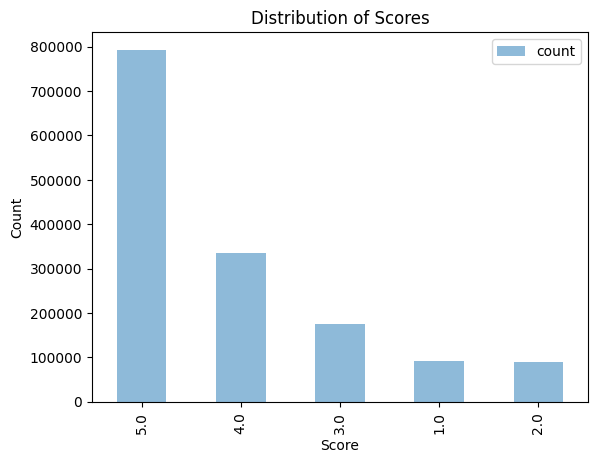

EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START


In [2]:
# Download the csv files into the `data/` directory.
trainingSet = pd.read_csv("./data/train.csv")
testingSet = pd.read_csv("./data/test.csv")

print("train.csv shape is ", trainingSet.shape)
print("test.csv shape is ", testingSet.shape)

trainingSet['Score'].value_counts().plot(kind='bar', legend=True, alpha=.5)
plt.title('Distribution of Scores')
plt.xlabel('Score')
plt.ylabel('Count')
plt.show()

print("EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START")

# Adding Features

In [3]:
def add_features_to(df):
    # Feature extraction
    df['Helpfulness'] = df['HelpfulnessNumerator'] / (df['HelpfulnessDenominator'] + 1)  # Prevent division by zero
    df['Helpfulness'] = df['Helpfulness'].fillna(0)
    
    # Convert Time to datetime
    df['ReviewTime'] = pd.to_datetime(df['Time'], unit='s')
    df['Year'] = df['ReviewTime'].dt.year
    df['Month'] = df['ReviewTime'].dt.month
    df['DayOfWeek'] = df['ReviewTime'].dt.dayofweek
    
    # Text length features
    df['Summary_length'] = df['Summary'].fillna('').apply(len)
    df['Text_length'] = df['Text'].fillna('').apply(len)
    
    return df

# Load the feature extracted files if they've already been generated
if exists('./data/X_train.csv') and exists('./data/X_submission.csv'):
    X_train = pd.read_csv("./data/X_train.csv")
    X_submission = pd.read_csv("./data/X_submission.csv")
else:
    # Process the DataFrame
    train = add_features_to(trainingSet)
    
    # The submission set is the testingSet with additional features
    X_submission = add_features_to(testingSet)
    
    # The training set is where the score is not null
    X_train = train[train['Score'].notnull()]
    
    X_submission.to_csv("./data/X_submission.csv", index=False)
    X_train.to_csv("./data/X_train.csv", index=False)

# Sample + Split into training and testing set

In [4]:
X_train, X_test, Y_train, Y_test = train_test_split(
    X_train,
    X_train['Score'],
    test_size=1/4.0,
    random_state=0,
    stratify=X_train['Score']  # 保持类别分布
)

# 重置索引，确保索引从 0 开始连续
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
Y_train = Y_train.reset_index(drop=True)
Y_test = Y_test.reset_index(drop=True)

# Now drop 'Score' from X_train and X_test, since we have Y_train and Y_test
X_train = X_train.drop(columns=['Score'])
X_test = X_test.drop(columns=['Score'])


# Feature Selection

In [5]:
features = [
    'HelpfulnessNumerator', 
    'HelpfulnessDenominator', 
    'Time', 
    'Helpfulness', 
    'Year', 
    'Month', 
    'DayOfWeek',
    'Summary_length',
    'Text_length',
    'UserId',
    'ProductId'
]

X_train_select = X_train[features].copy()
X_test_select = X_test[features].copy()
X_submission_select = X_submission[features].copy()

# 对 UserId 和 ProductId 进行编码
# 使用 LabelEncoder 将 UserId 和 ProductId 转换为数值类型
user_encoder = LabelEncoder()
product_encoder = LabelEncoder()

# 合并所有数据以确保编码一致
all_user_ids = pd.concat([X_train_select['UserId'], X_test_select['UserId'], X_submission_select['UserId']])
all_product_ids = pd.concat([X_train_select['ProductId'], X_test_select['ProductId'], X_submission_select['ProductId']])

user_encoder.fit(all_user_ids)
product_encoder.fit(all_product_ids)

X_train_select['UserId_encoded'] = user_encoder.transform(X_train_select['UserId'])
X_test_select['UserId_encoded'] = user_encoder.transform(X_test_select['UserId'])
X_submission_select['UserId_encoded'] = user_encoder.transform(X_submission_select['UserId'])

X_train_select['ProductId_encoded'] = product_encoder.transform(X_train_select['ProductId'])
X_test_select['ProductId_encoded'] = product_encoder.transform(X_test_select['ProductId'])
X_submission_select['ProductId_encoded'] = product_encoder.transform(X_submission_select['ProductId'])

# 移除原始的 UserId 和 ProductId
X_train_select = X_train_select.drop(columns=['UserId', 'ProductId'])
X_test_select = X_test_select.drop(columns=['UserId', 'ProductId'])
X_submission_select = X_submission_select.drop(columns=['UserId', 'ProductId'])

# Handle missing values
for df in [X_train_select, X_test_select, X_submission_select]:
    df['HelpfulnessNumerator'] = df['HelpfulnessNumerator'].fillna(0)
    df['HelpfulnessDenominator'] = df['HelpfulnessDenominator'].fillna(0)
    df['Helpfulness'] = df['Helpfulness'].fillna(0)
    df['Summary_length'] = df['Summary_length'].fillna(0)
    df['Text_length'] = df['Text_length'].fillna(0)
    df['Year'] = df['Year'].fillna(df['Year'].mode()[0])
    df['Month'] = df['Month'].fillna(df['Month'].mode()[0])
    df['DayOfWeek'] = df['DayOfWeek'].fillna(df['DayOfWeek'].mode()[0])
    df['Time'] = df['Time'].fillna(df['Time'].median())

# Text Preprocessing
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    if pd.isna(text):
        return ""
    text = text.lower()  # 转换为小写
    text = re.sub(r'[^a-z]', ' ', text)  # 移除非字母字符
    text = ' '.join([word for word in text.split() if word not in stop_words])  # 移除停用词
    return text

# 对文本进行预处理
X_train['Summary'] = X_train['Summary'].fillna('').apply(preprocess_text)
X_train['Text'] = X_train['Text'].fillna('').apply(preprocess_text)

X_test['Summary'] = X_test['Summary'].fillna('').apply(preprocess_text)
X_test['Text'] = X_test['Text'].fillna('').apply(preprocess_text)

X_submission['Summary'] = X_submission['Summary'].fillna('').apply(preprocess_text)
X_submission['Text'] = X_submission['Text'].fillna('').apply(preprocess_text)

# Sentiment Analysis Features
analyzer = SentimentIntensityAnalyzer()

def sentiment_features(text):
    if pd.isna(text):
        return pd.Series([0, 0, 0, 0])
    sentiment = analyzer.polarity_scores(text)
    return pd.Series([sentiment['compound'], sentiment['pos'], sentiment['neu'], sentiment['neg']])

# 添加情感细分特征
X_train_select[['Sentiment_Compound', 'Sentiment_Pos', 'Sentiment_Neu', 'Sentiment_Neg']] = X_train['Text'].apply(sentiment_features)
X_test_select[['Sentiment_Compound', 'Sentiment_Pos', 'Sentiment_Neu', 'Sentiment_Neg']] = X_test['Text'].apply(sentiment_features)
X_submission_select[['Sentiment_Compound', 'Sentiment_Pos', 'Sentiment_Neu', 'Sentiment_Neg']] = X_submission['Text'].apply(sentiment_features)

# 添加情感词汇频率特征
positive_words = set(['good', 'excellent', 'amazing', 'fantastic', 'positive', 'love'])
negative_words = set(['bad', 'poor', 'terrible', 'awful', 'negative', 'hate'])

def count_sentiment_words(text):
    pos_count = 0
    neg_count = 0
    if pd.isna(text):
        return pd.Series([pos_count, neg_count])
    words = text.split()
    for word in words:
        if word in positive_words:
            pos_count += 1
        elif word in negative_words:
            neg_count += 1
    return pd.Series([pos_count, neg_count])

# 应用到数据集
X_train_select[['Positive_Word_Count', 'Negative_Word_Count']] = X_train['Text'].apply(count_sentiment_words)
X_test_select[['Positive_Word_Count', 'Negative_Word_Count']] = X_test['Text'].apply(count_sentiment_words)
X_submission_select[['Positive_Word_Count', 'Negative_Word_Count']] = X_submission['Text'].apply(count_sentiment_words)

# 添加 Word_Count 特征
X_train_select['Word_Count'] = X_train['Text'].apply(lambda x: len(str(x).split()))
X_test_select['Word_Count'] = X_test['Text'].apply(lambda x: len(str(x).split()))
X_submission_select['Word_Count'] = X_submission['Text'].apply(lambda x: len(str(x).split()))

# 更新特征列表
features = [
    'HelpfulnessNumerator', 
    'HelpfulnessDenominator', 
    'Time', 
    'Helpfulness', 
    'Year', 
    'Month', 
    'DayOfWeek',
    'Summary_length',
    'Text_length',
    'UserId_encoded',
    'ProductId_encoded',
    'Sentiment_Compound',
    'Sentiment_Pos',
    'Sentiment_Neu',
    'Sentiment_Neg',
    'Positive_Word_Count',
    'Negative_Word_Count',
    'Word_Count'
]

# 更新特征集
X_train_select = X_train_select[features]
X_test_select = X_test_select[features]
X_submission_select = X_submission_select[features]

# Feature Engineering: Text Features
# Increase max_features to capture more information
tfidf_summary = TfidfVectorizer(max_features=2000, stop_words='english', ngram_range=(1,2))
tfidf_text = TfidfVectorizer(max_features=5000, stop_words='english', ngram_range=(1,2))

# Fit and transform the text data
tfidf_summary.fit(X_train['Summary'])
tfidf_text.fit(X_train['Text'])

summary_train_tfidf = tfidf_summary.transform(X_train['Summary'])
text_train_tfidf = tfidf_text.transform(X_train['Text'])

summary_test_tfidf = tfidf_summary.transform(X_test['Summary'])
text_test_tfidf = tfidf_text.transform(X_test['Text'])

summary_submission_tfidf = tfidf_summary.transform(X_submission['Summary'])
text_submission_tfidf = tfidf_text.transform(X_submission['Text'])

# Combine numerical and text features
X_train_final = hstack([csr_matrix(X_train_select.values), summary_train_tfidf, text_train_tfidf])
X_test_final = hstack([csr_matrix(X_test_select.values), summary_test_tfidf, text_test_tfidf])
X_submission_final = hstack([csr_matrix(X_submission_select.values), summary_submission_tfidf, text_submission_tfidf])

# Feature Scaling
scaler = StandardScaler(with_mean=False)  # with_mean=False for sparse matrices
X_train_scaled = scaler.fit_transform(X_train_final)
X_test_scaled = scaler.transform(X_test_final)
X_submission_scaled = scaler.transform(X_submission_final)

# Model Creation

In [6]:
# 分层模型

# 第一层模型：区分 5 分和非 5 分
# 创建新的标签，1 表示 5 分，0 表示非 5 分
Y_train_first_layer = (Y_train == 5.0).astype(int)
Y_test_first_layer = (Y_test == 5.0).astype(int)

# 从训练集中抽取一部分数据进行超参数调优
sample_size = min(100000, X_train_scaled.shape[0])  # 增加样本量
X_train_sample, _, Y_train_sample_first_layer, _ = train_test_split(
    X_train_scaled,
    Y_train_first_layer,
    train_size=sample_size,
    random_state=0,
    stratify=Y_train_first_layer
)

# 定义第一层模型的参数网格（更大的 C 值）
param_grid_first_layer = {
    'C': [1, 2, 5, 10],  # 增加 C 值的范围
    'penalty': ['l2'],
    'loss': ['squared_hinge'],  # 使用 'squared_hinge' 损失函数
    'class_weight': ['balanced']
}

# 创建 LinearSVC 对象
svc_first_layer = LinearSVC(random_state=0, max_iter=30000, dual=False)

# 创建 GridSearchCV 对象
grid_search_first_layer = GridSearchCV(
    estimator=svc_first_layer,
    param_grid=param_grid_first_layer,
    cv=3,  # 3-fold 交叉验证
    scoring='accuracy',
    n_jobs=-1  # 使用所有可用的CPU核心
)

# 在样本数据上执行网格搜索
grid_search_first_layer.fit(X_train_sample, Y_train_sample_first_layer)

# 输出最佳参数
print("Best parameters for first layer from GridSearchCV: ", grid_search_first_layer.best_params_)

# 使用最佳参数训练第一层模型（在全量训练数据上）
best_svc_first_layer = grid_search_first_layer.best_estimator_
best_svc_first_layer.fit(X_train_scaled, Y_train_first_layer)

# 对测试集进行第一层预测
Y_test_pred_first_layer = best_svc_first_layer.predict(X_test_scaled)

# 第二层模型：对非 5 分的评论，区分为中评分（3、4 分）和低评分（1、2 分）
# 使用布尔掩码选择非 5 分的样本
non_5_mask_train = (Y_train_first_layer == 0).values  # 非 5 分的样本
X_train_non_5 = X_train_scaled[non_5_mask_train]
Y_train_non_5 = Y_train[non_5_mask_train]

non_5_mask_test = (Y_test_pred_first_layer == 0)
X_test_non_5 = X_test_scaled[non_5_mask_test]
Y_test_non_5 = Y_test[non_5_mask_test]

# 创建新的标签，1 表示中评分（3、4 分），0 表示低评分（1、2 分）
Y_train_second_layer = np.where((Y_train_non_5 == 3.0) | (Y_train_non_5 == 4.0), 1, 0)

# 定义第二层模型的参数网格（中等 C 值）
param_grid_second_layer = {
    'C': [0.5, 1, 2],  # 调整 C 值范围
    'penalty': ['l2'],
    'loss': ['squared_hinge'],
    'class_weight': ['balanced']
}

# 第二层模型的训练
svc_second_layer = LinearSVC(random_state=0, max_iter=30000, dual=False)

# 超参数调优
grid_search_second_layer = GridSearchCV(
    estimator=svc_second_layer,
    param_grid=param_grid_second_layer,
    cv=3,
    scoring='accuracy',
    n_jobs=-1
)
grid_search_second_layer.fit(X_train_non_5, Y_train_second_layer)
print("Best parameters for second layer from GridSearchCV: ", grid_search_second_layer.best_params_)
svc_second_layer = grid_search_second_layer.best_estimator_

# 在全量数据上训练模型
svc_second_layer.fit(X_train_non_5, Y_train_second_layer)

# 对测试集进行第二层预测
Y_test_pred_second_layer = svc_second_layer.predict(X_test_non_5)

# 第三层模型A：对中评分（3、4 分）的评论，区分 3 分和 4 分
middle_mask_train = (Y_train_second_layer == 1)
X_train_middle = X_train_non_5[middle_mask_train]
Y_train_middle = Y_train_non_5[middle_mask_train]

# 对测试集进行相应的处理
middle_mask_test = (Y_test_pred_second_layer == 1)
X_test_middle = X_test_non_5[middle_mask_test]
Y_test_middle_true = Y_test_non_5[middle_mask_test]

# 定义第三层模型A的参数网格
param_grid_third_layer_middle = {
    'C': [0.5, 1.0, 1.5],  # 增加 C 值，进一步平衡决策边界
    'penalty': ['l2'],
    'loss': ['squared_hinge'],
    'class_weight': [{3.0: 2, 4.0: 1.5}]  # 为 3 星和 4 星分配新的权重
}

# 第三层模型A的训练
svc_third_layer_middle = LinearSVC(random_state=0, max_iter=30000, dual=False)

# 超参数调优
grid_search_third_layer_middle = GridSearchCV(
    estimator=svc_third_layer_middle,
    param_grid=param_grid_third_layer_middle,
    cv=3,
    scoring='accuracy',
    n_jobs=-1
)
grid_search_third_layer_middle.fit(X_train_middle, Y_train_middle)
print("Best parameters for third layer (middle scores) from GridSearchCV: ", grid_search_third_layer_middle.best_params_)
svc_third_layer_middle = grid_search_third_layer_middle.best_estimator_

# 在全量数据上训练模型
svc_third_layer_middle.fit(X_train_middle, Y_train_middle)

# 第三层模型B：对低评分（1、2 分）的评论，区分 1 分和 2 分
low_mask_train = (Y_train_second_layer == 0)
X_train_low = X_train_non_5[low_mask_train]
Y_train_low = Y_train_non_5[low_mask_train]

# 对测试集进行相应的处理
low_mask_test = (Y_test_pred_second_layer == 0)
X_test_low = X_test_non_5[low_mask_test]
Y_test_low_true = Y_test_non_5[low_mask_test]

# 定义第三层模型B的参数网格
param_grid_third_layer_low = {
    'C': [0.01, 0.05, 0.1],  # 调整 C 值范围
    'penalty': ['l2'],
    'loss': ['squared_hinge'],
    'class_weight': ['balanced']
}

# 第三层模型B的训练
svc_third_layer_low = LinearSVC(random_state=0, max_iter=30000, dual=False)

# 超参数调优
grid_search_third_layer_low = GridSearchCV(
    estimator=svc_third_layer_low,
    param_grid=param_grid_third_layer_low,
    cv=3,
    scoring='accuracy',
    n_jobs=-1
)
grid_search_third_layer_low.fit(X_train_low, Y_train_low)
print("Best parameters for third layer (low scores) from GridSearchCV: ", grid_search_third_layer_low.best_params_)
svc_third_layer_low = grid_search_third_layer_low.best_estimator_

# 在全量数据上训练模型
svc_third_layer_low.fit(X_train_low, Y_train_low)

# 对测试集进行第三层预测
Y_test_pred_third_layer_middle = svc_third_layer_middle.predict(X_test_middle)
Y_test_pred_third_layer_low = svc_third_layer_low.predict(X_test_low)

# 合并预测结果
Y_test_predictions = np.copy(Y_test_pred_first_layer)

# 第一层预测为 5 分的样本，标记为 5.0
Y_test_predictions[Y_test_pred_first_layer == 1] = 5.0

# 第一层预测为非 5 分，第二层预测为中评分（1）的样本，使用第三层模型A的预测结果（3.0 或 4.0）
middle_score_indices = np.where(non_5_mask_test)[0][middle_mask_test]
Y_test_predictions[middle_score_indices] = Y_test_pred_third_layer_middle

# 第一层预测为非 5 分，第二层预测为低评分（0）的样本，使用第三层模型B的预测结果（1.0 或 2.0）
low_score_indices = np.where(non_5_mask_test)[0][low_mask_test]
Y_test_predictions[low_score_indices] = Y_test_pred_third_layer_low


Best parameters for first layer from GridSearchCV:  {'C': 2, 'class_weight': 'balanced', 'loss': 'squared_hinge', 'penalty': 'l2'}
Best parameters for second layer from GridSearchCV:  {'C': 2, 'class_weight': 'balanced', 'loss': 'squared_hinge', 'penalty': 'l2'}
Best parameters for third layer (middle scores) from GridSearchCV:  {'C': 1.5, 'class_weight': {3.0: 2, 4.0: 1.5}, 'loss': 'squared_hinge', 'penalty': 'l2'}
Best parameters for third layer (low scores) from GridSearchCV:  {'C': 0.01, 'class_weight': 'balanced', 'loss': 'squared_hinge', 'penalty': 'l2'}


# Model Evaluation

Accuracy on testing set =  0.6410743908481806
              precision    recall  f1-score   support

         1.0       0.57      0.68      0.62     22798
         2.0       0.35      0.48      0.40     22419
         3.0       0.45      0.33      0.38     44021
         4.0       0.46      0.44      0.45     83807
         5.0       0.80      0.81      0.80    198291

    accuracy                           0.64    371336
   macro avg       0.53      0.55      0.53    371336
weighted avg       0.64      0.64      0.64    371336



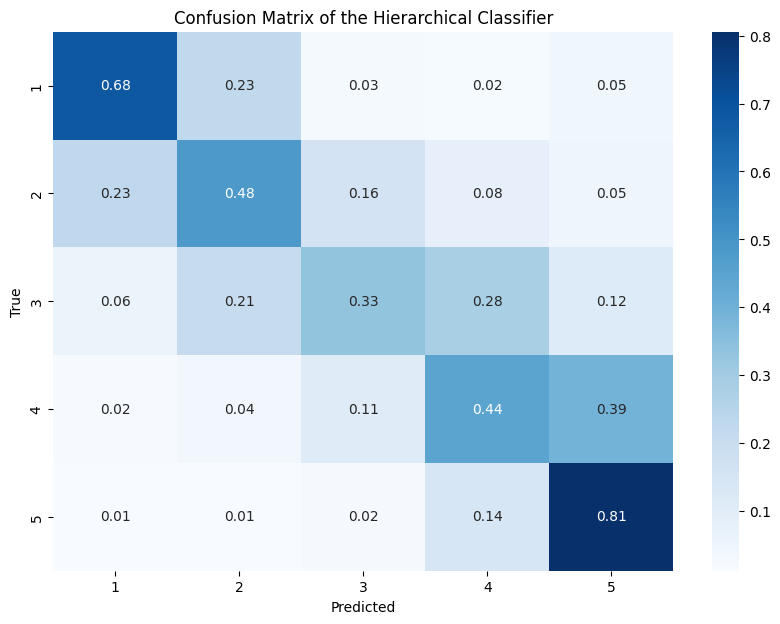

In [7]:
print("Accuracy on testing set = ", accuracy_score(Y_test, Y_test_predictions))
print(classification_report(Y_test, Y_test_predictions))

# Plot a confusion matrix
cm = confusion_matrix(Y_test, Y_test_predictions, labels=[1.0,2.0,3.0,4.0,5.0], normalize='true')
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='.2f',
            xticklabels=[1,2,3,4,5],
            yticklabels=[1,2,3,4,5])
plt.title('Confusion Matrix of the Hierarchical Classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# 对提交集进行预测
# 第一层预测
Y_submission_pred_first_layer = best_svc_first_layer.predict(X_submission_scaled)

# 筛选出预测为非 5 分的样本
non_5_mask_submission = (Y_submission_pred_first_layer == 0)
X_submission_non_5 = X_submission_scaled[non_5_mask_submission]

# 第二层预测
Y_submission_pred_second_layer = svc_second_layer.predict(X_submission_non_5)

# 对中评分样本进行第三层预测（3 星 vs. 4 星）
middle_mask_submission = (Y_submission_pred_second_layer == 1)
X_submission_middle = X_submission_non_5[middle_mask_submission]
Y_submission_pred_third_layer_middle = svc_third_layer_middle.predict(X_submission_middle)

# 对低评分样本进行第三层预测（1 星 vs. 2 星）
low_mask_submission = (Y_submission_pred_second_layer == 0)
X_submission_low = X_submission_non_5[low_mask_submission]
Y_submission_pred_third_layer_low = svc_third_layer_low.predict(X_submission_low)

# 合并预测结果
Y_submission_predictions = np.copy(Y_submission_pred_first_layer)

# 第一层预测为 5 分的样本，标记为 5.0
Y_submission_predictions[Y_submission_pred_first_layer == 1] = 5.0

# 第一层预测为非 5 分，第二层预测为中评分（1）的样本，使用第三层模型A的预测结果（3.0 或 4.0）
middle_score_indices_sub = np.where(non_5_mask_submission)[0][middle_mask_submission]
Y_submission_predictions[middle_score_indices_sub] = Y_submission_pred_third_layer_middle

# 第一层预测为非 5 分，第二层预测为低评分（0）的样本，使用第三层模型B的预测结果（1.0 或 2.0）
low_score_indices_sub = np.where(non_5_mask_submission)[0][low_mask_submission]
Y_submission_predictions[low_score_indices_sub] = Y_submission_pred_third_layer_low


# Create submission file

In [8]:
# Create submission file
X_submission['Score'] = Y_submission_predictions
submission = X_submission[['Id', 'Score']]
submission.to_csv("./data/submission.csv", index=False)